In [1]:
import numpy as np
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from skimage import io
import torch
import torch.nn as nn
from einops import rearrange, repeat
import pandas as pd
import sys
sys.path.insert(0, '../utils/')
from dataset import ChestImage64
import os
import time
import datetime

import matplotlib.pyplot as plt

from torchvision.models import vit_l_16, ViT_L_16_Weights,vit_b_16, ViT_B_16_Weights
from torch.utils.data import random_split, DataLoader, Dataset


In [2]:
csv_path = "../256pxImages/train_labels_256p_paired.csv"
root_path = '../256pxImages'

pairCSV = pd.read_csv(csv_path)
pairCSV['EncodedLabels'] = ''
print(pairCSV.shape)

for i in range(4, pairCSV.shape[1]-1):
    pairCSV['EncodedLabels'] = pairCSV['EncodedLabels'].astype(str) + pairCSV.iloc[:, i].astype(str) 
    if i < pairCSV.shape[1]-2:
        pairCSV['EncodedLabels'] = pairCSV['EncodedLabels'].astype(str) + "," 

pairCSV.head()

(30630, 19)


,Front Path,Lateral path,Patient,Study,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,EncodedLabels
0,Frontal\patient00002_study1_Frontal.png,Lateral\patient00002_study1_Lateral.png,patient00002,study1,1,1,1,1,0,1,1,1,0,0,1,1,0,0,"1,1,1,1,0,1,1,1,0,0,1,1,0,0"
1,Frontal\patient00004_study1_Frontal.png,Lateral\patient00004_study1_Lateral.png,patient00004,study1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"
2,Frontal\patient00005_study1_Frontal.png,Lateral\patient00005_study1_Lateral.png,patient00005,study1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"0,0,0,0,0,0,0,0,0,0,0,0,1,0"
3,Frontal\patient00009_study1_Frontal.png,Lateral\patient00009_study1_Lateral.png,patient00009,study1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,"1,1,0,0,0,0,0,0,0,0,0,0,0,0"
4,Frontal\patient00010_study1_Frontal.png,Lateral\patient00010_study1_Lateral.png,patient00010,study1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"


In [3]:
# test image loading
front_file = pairCSV.iloc[0, 0]
lat_file= pairCSV.iloc[0, 1]
label_test = pairCSV['EncodedLabels'].iloc[0]

test_path_front = os.path.join(root_path, front_file)
test_path_lat = os.path.join(root_path, lat_file)

label_test = [int(x) for x in label_test.split(",")]

print("label_test: ", label_test)

image_front = io.imread(test_path_front)
print(type(image_front))
image_front = torch.tensor(image_front)
print(image_front.size())

image_lat = io.imread(test_path_lat)
print(type(image_lat))
image_lat = torch.tensor(image_lat)
print(image_lat.size())

label_test:  [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
<class 'numpy.ndarray'>
torch.Size([256, 256])
<class 'numpy.ndarray'>
torch.Size([256, 256])


In [4]:
# load up the paired dataset
class PairedDataset(Dataset):
    def __init__(self, df, root_dir, label_col, transform = None):
        self.df = df
        self.root_dir = root_dir
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        if torch.is_tensor(index):
            index = index.tolist()

        # get the filename of the image
        file_front = self.df.iloc[index, 0]
        file_lat = self.df.iloc[index, 1]
        label = self.df[self.label_col].iloc[index]

        if type(label) == str:
            label = [int(x) for x in label.split(",")]

        # load the image from disk
        front_path = os.path.join(self.root_dir, file_front)
        lat_path = os.path.join(self.root_dir, file_lat)

        img_front = io.imread(front_path)
        img_lat = io.imread(lat_path)

        label = torch.tensor(label)
        label = label.float()

        img_front = torch.tensor(img_front)
        img_front = img_front.resize_((224, 224))
        img_front = repeat(img_front, "h w -> (repeat h) w", repeat = 3)
        img_front = rearrange(img_front, "(c h) w -> 1 c h w", c = 3)
        img_front = img_front.float()

        img_lat = torch.tensor(img_lat)
        img_lat = img_lat.resize_((224, 224))
        img_lat = repeat(img_lat, "h w -> (repeat h) w", repeat = 3)
        img_lat = rearrange(img_lat, "(c h) w -> 1 c h w", c = 3)
        img_lat = img_lat.float()

        img_pair=torch.cat((img_front,img_lat),0)


        # if self.transform:
            # label = self.transform(label)
            # img = self.transform(img)

        # return the image and its filename
        return img_pair, label
    

In [5]:
default_transform = ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1.transforms
pairDataset = PairedDataset(pairCSV, root_dir=root_path, label_col="EncodedLabels", transform=default_transform)

print(type(pairDataset))

<class '__main__.PairedDataset'>


In [6]:
# split into test train validate
train_size = int(0.7 * len(pairDataset))
val_size = int(0.1 * len(pairDataset))
test_size = int(0.2 * len(pairDataset))


train_dataset, val_dataset, test_dataset = random_split(pairDataset, [train_size, val_size, test_size])

print("Train Length: ", len(train_dataset))
print("Validation Length: ", len(val_dataset))
print("Test Length: ", len(test_dataset))

batchsize = 12

# make three different dataloaders
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batchsize, shuffle=True)


features, labels = next(iter(train_loader))
print(features.size())
print(features.dtype)

print(features[1, 1, :, :])

print(labels.size())
print(datetime.datetime.now().strftime("%H:%M:%S"))

Train Length:  21441
Validation Length:  3063
Test Length:  6126
torch.Size([12, 2, 3, 224, 224])
torch.float32
tensor([[[ 37.,  39.,  37.,  ...,  43.,  34.,  28.],
         [ 28.,  28.,  28.,  ..., 241., 239., 239.],
         [242., 240., 233.,  ..., 253., 253., 253.],
         ...,
         [184., 176., 177.,  ..., 217., 215., 215.],
         [215., 214., 214.,  ..., 218., 220., 215.],
         [213., 215., 213.,  ...,  32.,  34.,  39.]],

        [[ 37.,  39.,  37.,  ...,  43.,  34.,  28.],
         [ 28.,  28.,  28.,  ..., 241., 239., 239.],
         [242., 240., 233.,  ..., 253., 253., 253.],
         ...,
         [184., 176., 177.,  ..., 217., 215., 215.],
         [215., 214., 214.,  ..., 218., 220., 215.],
         [213., 215., 213.,  ...,  32.,  34.,  39.]],

        [[ 37.,  39.,  37.,  ...,  43.,  34.,  28.],
         [ 28.,  28.,  28.,  ..., 241., 239., 239.],
         [242., 240., 233.,  ..., 253., 253., 253.],
         ...,
         [184., 176., 177.,  ..., 217., 215., 2

In [7]:
front_features=features[:, 0, :, :, :]
print(front_features.size())

torch.Size([12, 3, 224, 224])


In [8]:
lat_features=features[:, 1, :, :, :]
print(lat_features.size())

torch.Size([12, 3, 224, 224])


In [9]:
class AllAttentionVIT(nn.Module):
    def __init__(self,weights_frontal,weights_lateral,code_size,num_classes,bottleneck=1024,drop_rate=0.1):
        
        super(AllAttentionVIT,self).__init__()

        #Initialize the model
        self.transformer_enc_frontal = vit_b_16(weights = weights_frontal)
        self.transformer_enc_frontal.heads = nn.Sequential(nn.Linear(768, code_size))
        self.transformer_enc_lateral = vit_b_16(weights = weights_lateral)
        self.transformer_enc_lateral.heads = nn.Sequential(nn.Linear(768, code_size))
        
        self.ff1 = nn.Linear(code_size*2,num_classes)
        #self.relu1 = nn.ReLU()
        #self.dropout = nn.Dropout(p = drop_rate)
        #self.ff2 = nn.Linear(bottleneck,num_classes)

    #Expect two images with the same class.
    def forward(self,x):

        #Split up paired images
        x_f=x[:, 0, :, :, :]
        x_l=x[:, 1, :, :, :]
        
        #Encode front and lateral embeddings
        x_f = self.transformer_enc_frontal(x_f)
        x_l = self.transformer_enc_frontal(x_l)

        #Concat embeddings. May want to experiment with convolutions.
        x = torch.cat((x_f,x_l),1)

        #Map concatenated embeddings onto the classes
        x = self.ff1(x)
        #x = self.relu1(x)
        #x = self.dropout(x)
        #x = self.ff2(x)

        return x

In [10]:
testWeights=ViT_B_16_Weights.DEFAULT
testModel = AllAttentionVIT(testWeights,testWeights,768,14)

# simple function to determine how many TRAINABILE parameters are in the model
def count_parameters(testModel):
    return sum(p.numel() for p in testModel.parameters() if p.requires_grad)

print(count_parameters(testModel))

172800014


In [11]:
# print out a list of the parameters we are training
for name,param in testModel.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

	 transformer_enc_frontal.class_token
	 transformer_enc_frontal.conv_proj.weight
	 transformer_enc_frontal.conv_proj.bias
	 transformer_enc_frontal.encoder.pos_embedding
	 transformer_enc_frontal.encoder.layers.encoder_layer_0.ln_1.weight
	 transformer_enc_frontal.encoder.layers.encoder_layer_0.ln_1.bias
	 transformer_enc_frontal.encoder.layers.encoder_layer_0.self_attention.in_proj_weight
	 transformer_enc_frontal.encoder.layers.encoder_layer_0.self_attention.in_proj_bias
	 transformer_enc_frontal.encoder.layers.encoder_layer_0.self_attention.out_proj.weight
	 transformer_enc_frontal.encoder.layers.encoder_layer_0.self_attention.out_proj.bias
	 transformer_enc_frontal.encoder.layers.encoder_layer_0.ln_2.weight
	 transformer_enc_frontal.encoder.layers.encoder_layer_0.ln_2.bias
	 transformer_enc_frontal.encoder.layers.encoder_layer_0.mlp.0.weight
	 transformer_enc_frontal.encoder.layers.encoder_layer_0.mlp.0.bias
	 transformer_enc_frontal.encoder.layers.encoder_layer_0.mlp.3.weight
	 tr

In [12]:
# batch accumulation parameter
target_accumulation=24
accum_iter = target_accumulation/batchsize  
print(accum_iter)

2.0


In [13]:
# now let's train this thing. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 20
learning_rate = 0.0034
criterion = nn.BCEWithLogitsLoss()

# make sure the model is running on the GPU if its available
testModel.to(device)

# Observe that all parameters are being optimized
params_to_update = testModel.parameters()
optimizer = torch.optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)


# optimizer = optim.Adam(model500k.parameters(), lr=learning_rate)

# start a clock 
print("Training Starting.")
start_time = time.time()

# create empty arrays to hold the loss results
training_losses = []
validation_losses = []
for epoch in range(epochs):
    phase = 'train'
    # set the model to training mode
    testModel.train()
    running_loss = 0.0

# zero the parameter gradients at the very beginning
    optimizer.zero_grad()


    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # ugh. This is gross. I should have done this step at the beginning for all of the datasets. 
        # zero the parameter gradients
        optimizer.zero_grad()
        # print("Here's the size of the inputs: ", inputs.size())
        # with torch.set_grad_enabled(phase == 'train'):
            # run the training data through the model
        outputs = testModel(inputs)

        #calculate the loss of the model
        loss = criterion(outputs, labels)

        #Gradient accumulation
        loss = loss
        loss.backward()

        running_loss += loss.item()

        # weights update for each gradient accumulation
        if ((i + 1) % accum_iter == 0) or (i + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()
        

            if ((i + 1) / accum_iter) % 500 == 0:    # record loss and test validation set every 500 gradient accumulations
                testModel.eval()
                v_running_loss = 0.0
                for v, data in enumerate(val_loader):
                    inputs, labels = data[0].to(device), data[1].to(device)

                    v_outputs = testModel(inputs)
                    v_loss = criterion(v_outputs, labels)
                    v_running_loss += v_loss.item()

                print("Time: ", datetime.datetime.now().strftime("%H:%M:%S"), "\tepoch: ", epoch+1, "batch: ", i+1, "Training loss: ", running_loss, "Validation loss ", v_running_loss)
                validation_losses.append(v_running_loss)
                training_losses.append(running_loss)
                running_loss = 0.0

    model_name= "model-multimodal_e" + str(epochs) + f"_lr{learning_rate:.0e}" + "_bs "+ str(batchsize)
    model_filepath="../logging//" + model_name + "_gradacc_nodrop.pth"

    print(model_filepath)

    torch.save(testModel.state_dict(), model_filepath)  


end_time = time.time()
train_time = end_time - start_time
print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
print('Finished Training')
    

Training Starting.
Time:  23:54:14 	epoch:  1 batch:  1000 Training loss:  573.4410420954227 Validation loss  146.64838421344757
../logging//model-multimodal_e20_lr3e-03_bs 12_gradacc_nodrop.pth
Time:  00:10:58 	epoch:  2 batch:  1000 Training loss:  535.3525197803974 Validation loss  139.9048591852188
../logging//model-multimodal_e20_lr3e-03_bs 12_gradacc_nodrop.pth
Time:  00:27:17 	epoch:  3 batch:  1000 Training loss:  501.0550397336483 Validation loss  126.35874739289284
../logging//model-multimodal_e20_lr3e-03_bs 12_gradacc_nodrop.pth
Time:  00:43:36 	epoch:  4 batch:  1000 Training loss:  491.1478876173496 Validation loss  123.81933218240738
../logging//model-multimodal_e20_lr3e-03_bs 12_gradacc_nodrop.pth
Time:  00:59:56 	epoch:  5 batch:  1000 Training loss:  477.6825442612171 Validation loss  125.39675071835518
../logging//model-multimodal_e20_lr3e-03_bs 12_gradacc_nodrop.pth
Time:  01:16:36 	epoch:  6 batch:  1000 Training loss:  469.41102173924446 Validation loss  123.879303

In [14]:
print(type(outputs))
print(outputs.size())
#print(outputs[1, :])
print(outputs)
print(labels.size())
#print(labels[1, :])
print(labels)
print(outputs.dtype)
print(labels.dtype)
print(loss)

print(training_losses)

<class 'torch.Tensor'>
torch.Size([9, 14])
tensor([[ 0.7777,  0.4924,  0.2549, -2.0368, -0.7276, -0.9207, -1.2739, -0.4648,
         -2.7613, -0.7140, -1.5608, -0.6553, -0.4229, -1.6931],
        [ 0.9465,  0.8030, -1.0154, -2.7766, -0.5661, -2.6643, -2.9966, -2.0709,
         -4.2062, -2.1585, -2.2636, -1.8323, -0.6298, -0.9423],
        [ 0.5549,  0.0441,  2.3346, -1.0762, -1.2719,  1.3595,  0.8955,  1.5831,
         -1.7152,  1.1046,  0.2225,  1.5098, -1.3559, -2.4570],
        [-1.1147, -1.3933, -1.7959, -3.6662, -2.6506, -3.2269, -3.0562, -2.3172,
         -4.7559, -2.7542, -2.5362, -1.9790, -1.3874,  0.0630],
        [-1.3007, -1.8743, -0.7358, -2.0096, -2.2818, -1.5462, -1.1014, -1.4754,
         -3.3545, -1.9182, -1.1387, -0.3059, -1.7324, -0.2215],
        [-1.4328, -1.6334, -1.7109, -1.8433, -1.8955, -2.5180, -2.0537, -2.7390,
         -3.8142, -2.9839, -2.0316, -1.6495, -1.3078,  0.1542],
        [-0.3777, -0.5700, -0.1404, -2.7327, -1.9813, -1.1909, -1.4807, -0.5194,
      

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


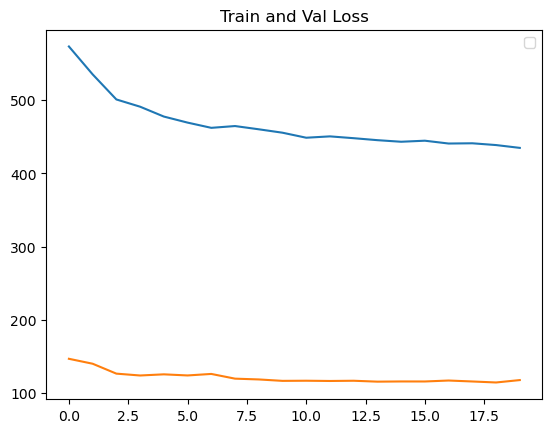

In [15]:
plt.title("Train and Val Loss")
plt.plot(training_losses)
plt.plot(validation_losses)
plt.legend()